In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hyperiax
from jax.random import PRNGKey, split
import jax
from jax import numpy as jnp
from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda
from hyperiax.models.functional import pass_up
from hyperiax.tree.topology import symmetric_topology
from hyperiax.tree import HypTree
from hyperiax.plotting import plot_tree_text, plot_tree, plot_tree_2d_scatter
from matplotlib import pyplot as plt
import jax

In [3]:
key = PRNGKey(0)

In [4]:
topology = symmetric_topology(height=3, degree=2)
plot_tree_text(topology)

                 None
        ┌─────────┴─────────┐
       None                None        
   ┌────┴────┐         ┌────┴────┐     
  None      None      None      None   
 ┌─┴──┐    ┌─┴──┐    ┌─┴──┐    ┌─┴──┐  
None None None None None None None None


In [5]:
tree = HypTree(topology)

tree.add_property('noise', shape=(2,))
tree.add_property('edge_length', shape=(1,))
tree.add_property('value', shape=(2,))

In [6]:
key, subkey = split(key)
tree.data['edge_length'] = jnp.exp(-jnp.log(2)*tree.node_depths)

In [7]:
key, subkey = split(key)
tree.data['noise'] = jax.random.normal(subkey, shape=tree.data['noise'].shape)

In [8]:
@jax.jit
def down(noise, edge_length,parent_value, **args):
    return {'value': jnp.sqrt(edge_length)*noise+parent_value}

In [9]:
tree.data['value'] = tree.data['value'].at[0].set(tree.data['noise'][0])

In [10]:
downmodel = DownLambda(down_fn=down)
exe = OrderedExecutor(downmodel)

In [11]:
exe.down(tree)

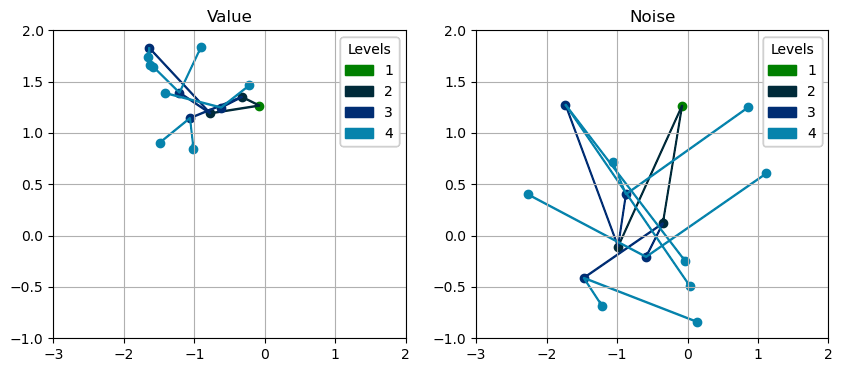

In [12]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
for a in ax:
    a.set_xlim(-3,2)
    a.set_ylim(-1,2)
plot_tree_2d_scatter(tree, 'value', ax=ax[0])
ax[0].set_title('Value')
plot_tree_2d_scatter(tree, 'noise', ax=ax[1])
ax[1].set_title('Noise')

In [13]:
tree.add_property('estimated_value', shape=(2,))
leaf_data = tree.data['value'][tree.is_leaf]
tree.data['estimated_value'] = tree.data['estimated_value'].at[tree.is_leaf].set(leaf_data)

In [14]:
def transform(child_weighted_value,child_inverse_edge_length, **kwargs):
    return {'estimated_value': child_weighted_value/child_inverse_edge_length}

def up(estimated_value, edge_length, **kwargs):
    return {'weighted_value': estimated_value/edge_length, 'inverse_edge_length':1/edge_length}
upmodel = UpLambdaReducer(up, transform, 
                   reductions={
                       'weighted_value': 'sum', 
                       'inverse_edge_length': 'sum'
                    }
        )
upward_exe = OrderedExecutor(upmodel)

In [15]:
upward_exe.up(tree)

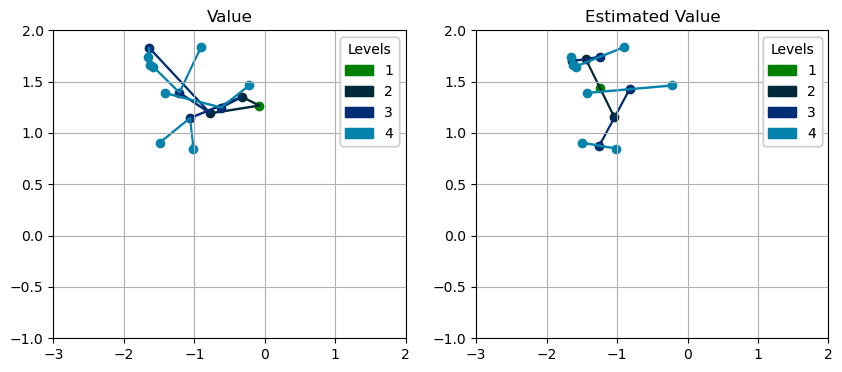

In [16]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
for a in ax:
    a.set_xlim(-3,2)
    a.set_ylim(-1,2)
plot_tree_2d_scatter(tree, 'value', ax=ax[0])
ax[0].set_title('Value')
plot_tree_2d_scatter(tree, 'estimated_value', ax=ax[1])
ax[1].set_title('Estimated Value')

In [17]:
pre_tree = HypTree(topology, precompute_child_gathers=True)
pre_tree.data = tree.data.copy()

In [18]:
def up(child_estimated_value, child_edge_length, **kwargs):
    inv_el = 1/child_edge_length
    normalizer = inv_el.sum(axis=1)

    return {'estimated_value': jnp.einsum('bcd,bc1->bd', child_estimated_value, inv_el)/normalizer}

In [19]:
upmodel = UpLambda(up_fn=up)
upmodelexe = OrderedExecutor(upmodel)

In [20]:
res = upmodelexe.up(pre_tree)

In [21]:
(pre_tree.data['estimated_value'] == tree.data['estimated_value']).all()

Array(True, dtype=bool)

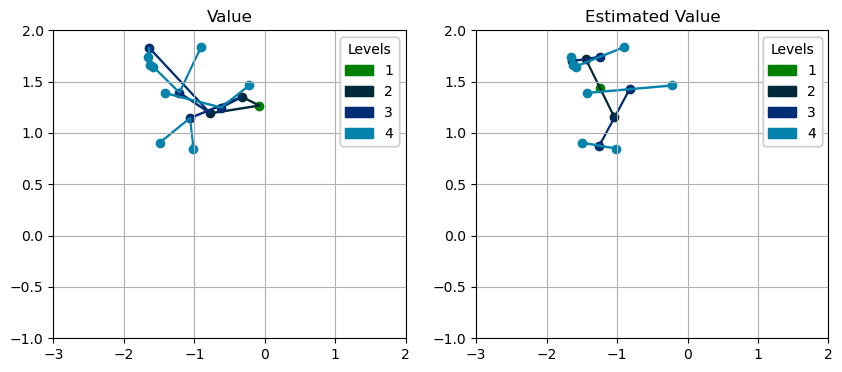

In [22]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
for a in ax:
    a.set_xlim(-3,2)
    a.set_ylim(-1,2)
plot_tree_2d_scatter(pre_tree, 'value', ax=ax[0])
ax[0].set_title('Value')
plot_tree_2d_scatter(pre_tree, 'estimated_value', ax=ax[1])
ax[1].set_title('Estimated Value')

In [23]:
from hyperiax.models.prebuilts import PhyloMeanModel

In [25]:
pme = PhyloMeanModel()
exe = OrderedExecutor(pme)

In [26]:
exe.up(tree)